In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
import wrangle as w
import explore as ex
import evaluate

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer
# Regression Modeling
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

In [2]:
# w.get_zillow_data(cached=False) 

In [3]:
df = w.wrangle_zillow()

# Tax Rate distribution

In [4]:
tax_df = w.tax_rate_distribution()

In [5]:
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32213 entries, 14634203 to 17073441
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fips        32213 non-null  float64
 1   tax_value   32213 non-null  float64
 2   tax_amount  32213 non-null  float64
 3   tax_rate    32213 non-null  float64
dtypes: float64(4)
memory usage: 1.2 MB


In [6]:
tax_df.groupby('fips').mean()

,tax_value,tax_amount,tax_rate
fips,,,
6037.0,389935.915058,4843.139250,0.012718
6059.0,448385.581302,5164.518675,0.011725
6111.0,416642.548092,4712.725178,0.011399


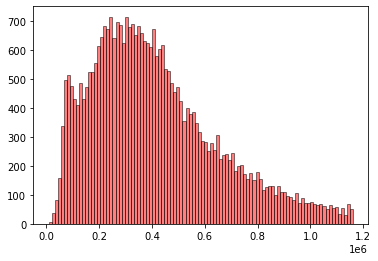

In [7]:
plt.hist(data=tax_df, x='tax_value', bins=100, color='red', alpha=.5, ec='black', label='Tax Value Distribution of 3 Southern Californian Counties')

plt.show()

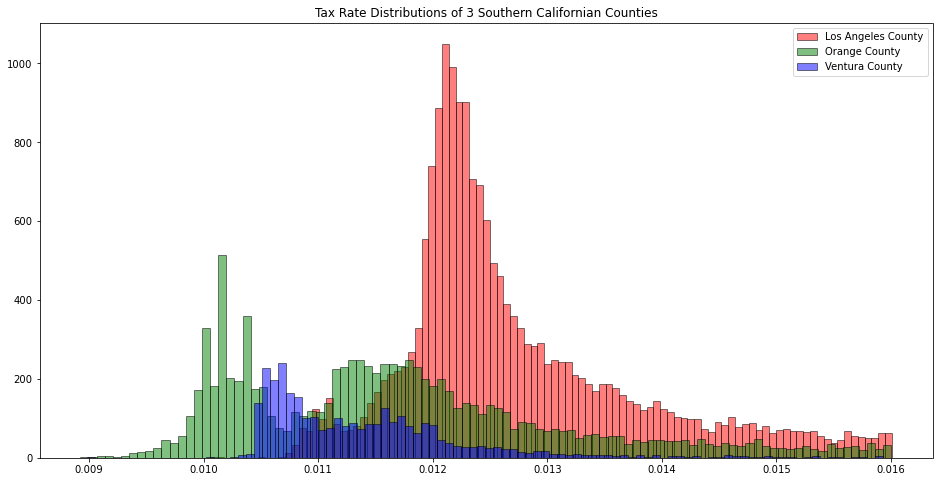

In [8]:
plt.figure(figsize=(16,8))

plt.hist(data=tax_df[tax_df.fips == 6037], x='tax_rate', bins=100, color='red', alpha=.5, ec='black', label='Los Angeles County')
plt.hist(data=tax_df[tax_df.fips == 6059], x='tax_rate',  bins=100, color='green', alpha=.5, ec='black', label='Orange County')
plt.hist(data=tax_df[tax_df.fips == 6111], x='tax_rate', bins=100, color="blue", alpha=.5, ec='black', label='Ventura County')

plt.title('Tax Rate Distributions of 3 Southern Californian Counties')
plt.legend()
plt.show()

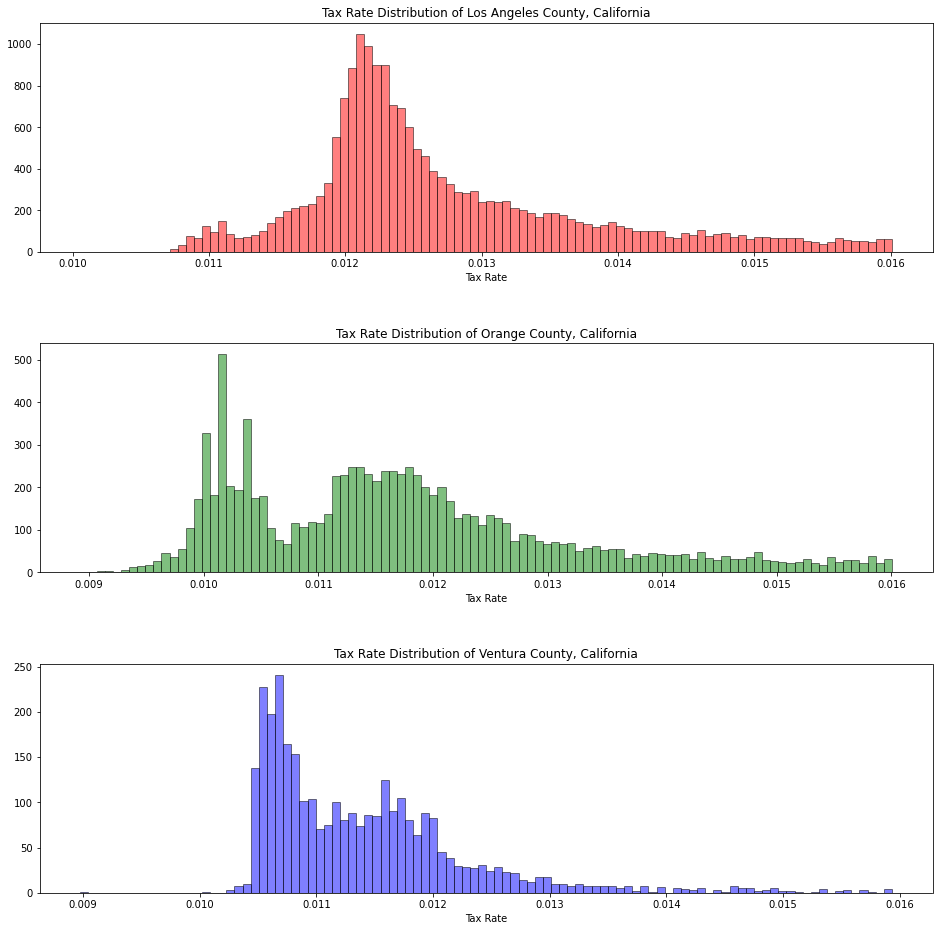

In [9]:
plt.figure(figsize=(16,16))

plt.subplot(3, 1, 1, xlabel='Tax Rate', title='Tax Rate Distribution of Los Angeles County, California')
plt.hist(data=tax_df[tax_df.fips == 6037], x='tax_rate', bins=100, color='red', alpha=.5, ec='black')

plt.subplot(3, 1, 2, xlabel='Tax Rate', title='Tax Rate Distribution of Orange County, California')
plt.hist(data=tax_df[tax_df.fips == 6059], x='tax_rate',  bins=100, color='green', alpha=.5, ec='black')

plt.subplot(3, 1, 3, xlabel='Tax Rate', title='Tax Rate Distribution of Ventura County, California')
plt.hist(data=tax_df[tax_df.fips == 6111], x='tax_rate', bins=100, color="blue", alpha=.5, ec='black')

plt.subplots_adjust(hspace=.4)
plt.show()


# Exploration

In [10]:
target = 'tax_value'

In [11]:
w.select_kbest(df, target, 7)

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'age_of_home',
 'beds_and_baths',
 'beds_per_sqft']

In [12]:
w.rfe(df,target,7)

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'age_of_home',
 'beds_and_baths',
 'baths_per_sqft']

In [13]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.train_validate_test_split(df, target, 42)

In [14]:
train.shape, validate.shape, test.shape

((20515, 12), (8793, 12), (7328, 12))

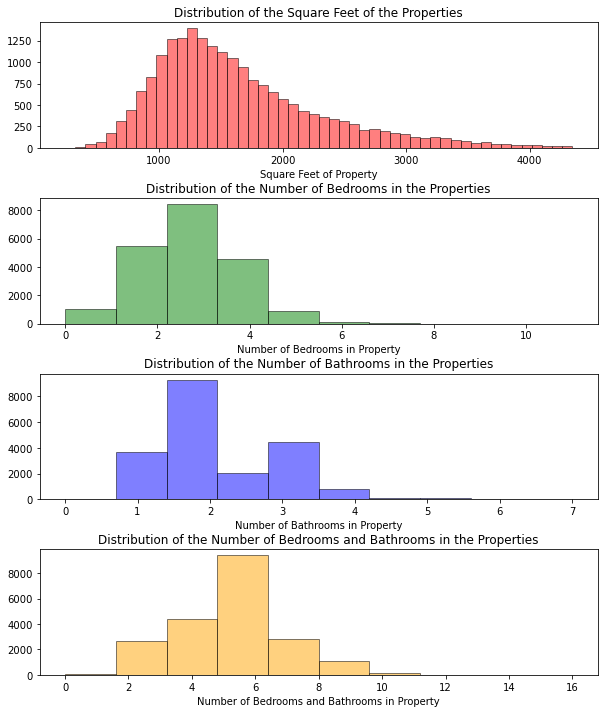

In [15]:
plt.figure(figsize=(10,12))

plt.subplot(4, 1, 1, xlabel='Square Feet of Property', title='Distribution of the Square Feet of the Properties')
plt.hist(data=train, x='square_feet', bins=50, color='red', alpha=.5, ec='black')

plt.subplot(4, 1, 2, xlabel='Number of Bedrooms in Property', title='Distribution of the Number of Bedrooms in the Properties')
plt.hist(data=train, x='bedrooms', color='green', alpha=.5, ec='black')

plt.subplot(4, 1, 3, xlabel='Number of Bathrooms in Property', title='Distribution of the Number of Bathrooms in the Properties')
plt.hist(data=train, x='bathrooms', color='blue', alpha=.5, ec='black')

plt.subplot(4, 1, 4, xlabel='Number of Bedrooms and Bathrooms in Property', title='Distribution of the Number of Bedrooms and Bathrooms in the Properties')
plt.hist(data=train, x='beds_and_baths', color='orange', alpha=.5, ec='black')


plt.subplots_adjust(hspace=.4)

plt.show()


# Scale the data

In [16]:
object_cols = w.get_object_cols(train)

In [17]:
numeric_cols = w.get_numeric_X_cols(X_train, object_cols)

In [18]:
X_train_scaled, X_validate_scaled, X_test_scaled = w.min_max_scale(X_train, X_validate, X_test, numeric_cols)

# Statisical Tests

### Overview of Statistical Tests

- Correlation tests are used to check if two samples are related. They are often used for feature selection and multivariate analysis in data preprocessing and exploration.

- A T-test lets us compare a categorical and a continuous variable by comparing the mean of the continuous variable by subgroups based on the categorical variable

All statistical testing will be run using a 95% confidence level, making the alpha value 5% or 0.05. If the p-value is less than the alpha value we can reject the null hypothesis (H<sub>0</sub>) and move forward with the alternate hypothesis (H<sub>1</sub>).


### Hypotheses

For all Correlation tests below: 

- The H<sub>0</sub> is that there is no correlation between the two samples.

- The H<sub>1</sub> is that there is a correlation between the two samples.

For the T-test:

- The H<sub>0</sub> is that there is no difference in the means of the LA County Tax rates.
- The H<sub>1</sub> is that the LA County Tax Rate is a different mean than the entire population.

Because of the T-test hypothesis, I will be conducting a 1 sample T-test.

In [19]:
r, p = stats.pearsonr(X_train_scaled.bathrooms, y_train)
round(r,4), round(p, 4)

(0.4362, 0.0)

In [20]:
r, p = stats.pearsonr(X_train_scaled.bedrooms, y_train)
round(r,4), round(p, 4)

(0.2572, 0.0)

In [21]:
r, p = stats.pearsonr(X_train_scaled.square_feet, y_train)
round(r,4), round(p, 4)

(0.5227, 0.0)

In [22]:
r, p = stats.pearsonr(X_train_scaled.beds_and_baths, y_train)
round(r,4), round(p, 4)

(0.3821, 0.0)

In [23]:
r, p = stats.pearsonr(X_train_scaled.bathrooms, X_train_scaled.square_feet)
round(r,4), round(p, 4)

(0.7484, 0.0)

In [24]:
la_county = tax_df[tax_df.fips == 6037]

In [25]:
t, p = stats.ttest_1samp(la_county.tax_rate, tax_df.tax_rate.mean())
round(t,4), round(p, 4)

(57.0874, 0.0)

### Results of Statistical Testing

Correlation results between the following features:
- bathrooms and tax value: t-statistic = 0.3998, p-value = 0.0
- bedrooms and tax value: t-statistic = 0.2363, p-value = 0.0
- square feet and tax value: t-statistic = 0.4752, p-value = 0.0
- total number of bedrooms and bathrooms and tax value: t-statistic = 0.3497, p-value = 0.0
- bathrooms and square feet: t-statistic = 0.7379, p-value = 0.0

All correlation tests reject the H<sub>0</sub> and can move forward with the corresponding H<sub>1</sub>.


One Sample T-test results are as follows:

- The t-statistic = 57.0874, and the p-value = 0.0.

There is enough evidence to reject the H<sub>0</sub> and move forward with the H<sub>1</sub> indicating that the LA country tax rate mean is significantly different from the tax rate of all 3 counties.

# Modeling

## Baseline

In [26]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [27]:
value_pred_mean = y_train.tax_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

value_pred_median = y_train.tax_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

In [28]:
# RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean) ** (1/2)

# Storing mean baseline values
rmse_train_baseline_mean = rmse_train
rmse_validate_baseline_mean = rmse_validate

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median) ** (1/2)

# Storing median baseline values
rmse_train_baseline_median = rmse_train
rmse_validate_baseline_median = rmse_validate

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  269332.46 
Validate/Out-of-Sample:  275025.15
RMSE using Median
Train/In-Sample:  274408.87 
Validate/Out-of-Sample:  281134.48


## Linear Regression (OLS)

In [29]:
lm = LinearRegression(normalize=True)


lm.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm) ** (1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  216726.17848473007 
Validation/Out-of-Sample:  222488.02517530342


### OLS Model R<sup>2</sup> Value

In [30]:
r2_score_ols = r2_score(y_validate.tax_value, y_validate.value_pred_lm)
r2_score_ols

0.3452434283429132

## TweedieRegressor (GLM)

In [31]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm) ** (1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  219739.0624102195 
Validation/Out-of-Sample:  225543.98000445


### Tweedie Regressor Model R<sup>2</sup> Value

In [32]:
r2_score_glm = r2_score(y_validate.tax_value, y_validate.value_pred_glm)
r2_score_glm

0.3271332572560617

## LassoLars

In [33]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lars) ** (1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  216727.60656733855 
Validation/Out-of-Sample:  222489.29275271893


### Lasso Lars Model R<sup>2</sup> Value

In [34]:
r2_score_lars = r2_score(y_validate.tax_value, y_validate.value_pred_lars)
r2_score_lars

0.3452359676536787

In [35]:
r2_score_lars, r2_score_glm, r2_score_ols

(0.3452359676536787, 0.3271332572560617, 0.3452434283429132)

## Linear Regression Model Test

In [36]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.value_pred_lm) ** (1/2)

print("RMSE for LassoLars Model\nOut-of-Sample Performance: ", rmse_test)

RMSE for LassoLars Model
Out-of-Sample Performance:  214690.35528481065


In [46]:
print(f'Baseline Performance:\nRSME mean: {round(rmse_train_baseline_mean, 3)}\nRSME median: {round(rmse_train_baseline_median,3)}\n')


print("RMSE for Lasso + Lars Train and Validate Performance:\nTraining/In-Sample: ", round(rmse_train,3), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,3), '\n')

print("RMSE for LassoLars Model Test Performance:\nOut-of-Sample Performance: ", rmse_test)
print(f'The Linear Regession model has an R_squared of {round(r2_score_ols, 3)}')

Baseline Performance:
RSME mean: 269332.461
RSME median: 274408.871

RMSE for Lasso + Lars Train and Validate Performance:
Training/In-Sample:  216727.607 
Validation/Out-of-Sample:  222489.293 

RMSE for LassoLars Model Test Performance:
Out-of-Sample Performance:  214690.35528481065
The Linear Regession model has an R_squared of 0.345


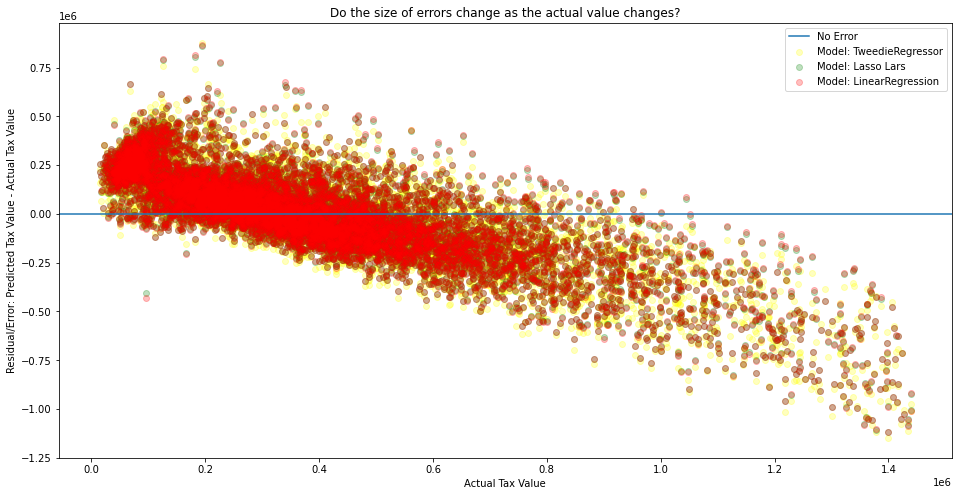

In [49]:
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.value_pred_glm - y_validate.tax_value, 
            alpha=.25, color="yellow", s=None, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lars - y_validate.tax_value, 
            alpha=.25, color="green", s=None, label="Model: Lasso Lars")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm - y_validate.tax_value , 
            alpha=.25, color="red", s=None, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

In [39]:
# plt.figure(figsize=(14,10))


# sns.jointplot(data = train, 
#               x = 'tax_value', 
#               y = 'latitude', 
#               kind = 'kde', 
#               cmap = 'Greens',
#               fill = True)


# plt.ylabel('South', loc='bottom')
# plt.ylabel('Latitude', loc='center')
# plt.ylabel('North', loc='top') 


# plt.show()

# sns.jointplot(data = train, 
#               x = 'square_feet', 
#               y = 'latitude', 
#               kind = 'kde', 
#               cmap = 'Blues',
#               fill = True)

# plt.show()

In [40]:
# plt.figure(figsize=(10,8))


# sns.jointplot(data = train, 
#               x = 'longitude', 
#               y = 'tax_value', 
#               kind = 'kde', 
#               cmap = 'Greens',
#               fill = True)

# plt.show()

# sns.jointplot(data = train, 
#               x = 'longitude', 
#               y = 'square_feet', 
#               kind = 'kde', 
#               cmap = 'Blues',
#               fill = True)

# plt.show()